📍 Kolom longitude: Longitude
📍 Kolom latitude: Latitude


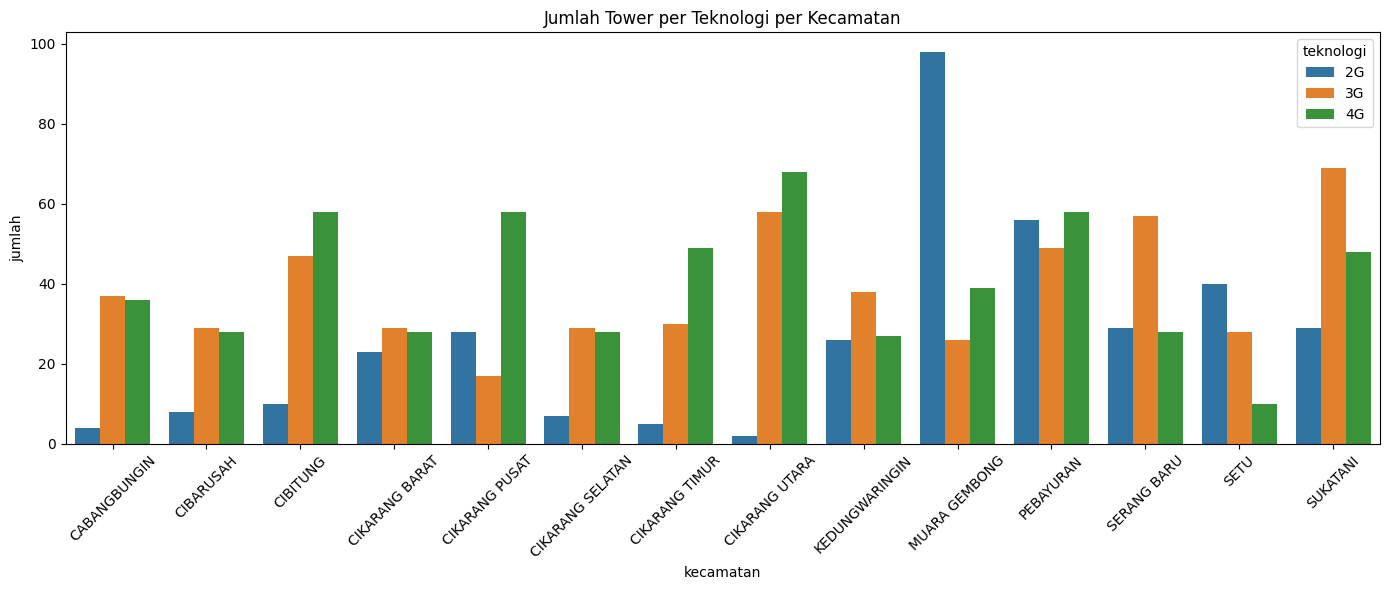

C:\Users\DJPPI\AppData\Local\Temp\ipykernel_5608\3042095097.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged[kolom] = pd.to_numeric(df_merged[kolom].replace('-', np.nan), errors='coerce')


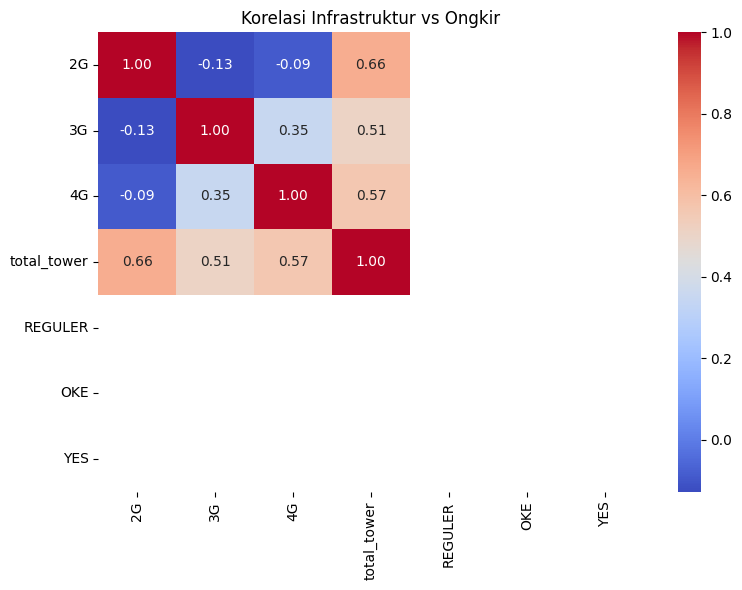

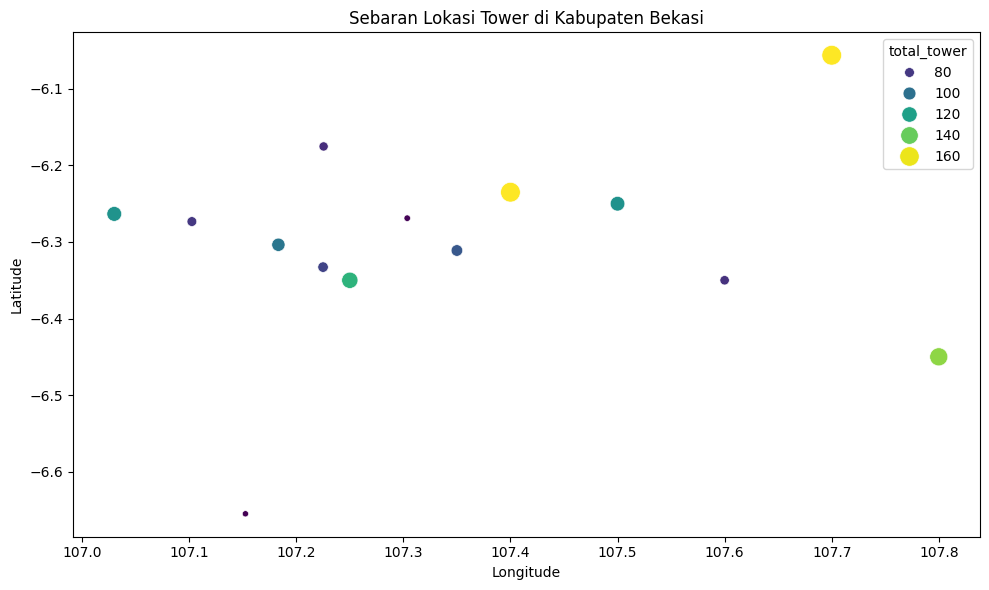

10 Wilayah Prioritas Penguatan Sinyal:
           kecamatan  total_tower  REGULER  prioritas_score
5   CIKARANG SELATAN           64     9000       140.625000
1          CIBARUSAH           65     9000       138.461538
0       CABANGBUNGIN           77     9000       116.883117
12              SETU           78     9000       115.384615
3     CIKARANG BARAT           80     9000       112.500000
6     CIKARANG TIMUR           84     9000       107.142857
8     KEDUNGWARINGIN           91     9000        98.901099
4     CIKARANG PUSAT          103     9000        87.378641
11       SERANG BARU          114     9000        78.947368
2           CIBITUNG          115     9000        78.260870


In [3]:
# ==========================================
# Analisis Infrastruktur Tower & Ongkir JNE
# Kabupaten Bekasi
# ==========================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# === STEP 1: BACA DATA ===
df_tower = pd.read_excel(r"D:\JUPITER\KEC KAB BEKASI_DATA DUMMY.xlsx")
df_ongkir = pd.read_excel(r"D:\JUPITER\ONGKIR.xlsx", skiprows=1)

# === STEP 2: NORMALISASI KECAMATAN ===
df_tower['Nama Kecamatan'] = df_tower['Nama Kecamatan'].str.strip().str.upper()
df_ongkir['Kecamatan'] = df_ongkir['Kecamatan'].str.strip().str.upper()

# === STEP 3: GABUNGKAN DATA ===
df_tower['total_tower'] = df_tower[['2G', '3G', '4G']].sum(axis=1)
df_merged = pd.merge(df_tower, df_ongkir, left_on='Nama Kecamatan', right_on='Kecamatan', how='inner')
df_merged['kecamatan'] = df_merged['Kecamatan']
df_merged.drop(columns=['Nama Kecamatan', 'Kecamatan'], inplace=True)

# Rename kolom ongkir agar seragam
df_merged.rename(columns={
    'REG (1-2 hari)': 'REGULER',
    'OKE (2-3 hari)': 'OKE',
    'YES (1 hari)': 'YES'
}, inplace=True)

# === STEP 4: PERBAIKI FORMAT KOORDINAT ===
def format_koordinat(x):
    x = str(x).replace('-', '').zfill(7)
    return float(x[:3] + '.' + x[3:])

# Deteksi kolom koordinat secara otomatis
kolom_long = next((c for c in df_merged.columns if re.search('long', c.lower())), None)
kolom_lat = next((c for c in df_merged.columns if re.search('lat', c.lower())), None)

print(f"📍 Kolom longitude: {kolom_long}")
print(f"📍 Kolom latitude: {kolom_lat}")

if kolom_long and kolom_lat:
    df_merged['longitude'] = df_merged[kolom_long].apply(format_koordinat)
    df_merged['latitude'] = df_merged[kolom_lat].apply(format_koordinat) * -1
else:
    print("❌ Kolom koordinat tidak ditemukan. Cek nama kolom kamu.")

# === STEP 5: VISUALISASI JUMLAH TOWER ===
df_melt = df_merged.melt(id_vars='kecamatan', value_vars=['2G', '3G', '4G'], var_name='teknologi', value_name='jumlah')
plt.figure(figsize=(14,6))
sns.barplot(data=df_melt, x='kecamatan', y='jumlah', hue='teknologi')
plt.title("Jumlah Tower per Teknologi per Kecamatan")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === STEP 6: KORELASI TOWER & ONGKIR ===
for kolom in ['REGULER', 'OKE', 'YES']:
    df_merged[kolom] = pd.to_numeric(df_merged[kolom].replace('-', np.nan), errors='coerce')

plt.figure(figsize=(8,6))
corr = df_merged[['2G', '3G', '4G', 'total_tower', 'REGULER', 'OKE', 'YES']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Infrastruktur vs Ongkir")
plt.tight_layout()
plt.show()

# === STEP 7: PETA SEBARAN TOWER ===
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_merged,
    x='longitude',
    y='latitude',
    hue='total_tower',
    size='total_tower',
    sizes=(20, 200),
    palette='viridis'
)
plt.title("Sebaran Lokasi Tower di Kabupaten Bekasi")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# === STEP 8: REKOMENDASI WILAYAH PRIORITAS ===
df_merged['prioritas_score'] = df_merged['REGULER'] / df_merged['total_tower']
top_prioritas = df_merged.sort_values(by='prioritas_score', ascending=False)[['kecamatan', 'total_tower', 'REGULER', 'prioritas_score']].head(10)
print("10 Wilayah Prioritas Penguatan Sinyal:")
print(top_prioritas)

# === STEP 9: SIMPAN KE EXCEL ===
df_merged.to_excel(r"D:\JUPITER\HASIL_ANALISIS_BEKASI.xlsx", index=False)
top_prioritas.to_excel(r"D:\JUPITER\REKOMENDASI_PRIORITAS_SINYAL.xlsx", index=False)